# Notebook: data_preparation.ipynb

Este cuaderno tiene como objetivo preparar los datos espaciales requeridos para realizar análisis del departamento Valle del Cauca. A lo largo de este cuaderno realizaremos las siguientes tareas: 
-Carga de capas vectoriales (shapefiles).
-Recorte y reproyección al sistema de referencia oficial MAGNA-SIRGAS (EPSG:3116).
-Validación de coberturas para análisis espacial posteriores.
Las capas utilizadas representan aspectos del territorio: vías, curvas de nivel, pendientes, cobertura del suelo, áreas protegidas e hidrografía

# 1. Cargue de librerias 
En esta sección se importan las principales librerías que permiten manipular, visualizar y analizar datos geoespaciales. Cada una cumple un rol específico dentro del flujo de trabajo.

In [19]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import contextily as ctx
import os

### El objetivo de esta sección es filtrar y preparar el límite departamental del Valle del Cauca a partir de una capa nacional de municipios. Este límite se usará como máscara espacial para recortar y reproyectar otras capas de información.

A continuación importamos el *stack* principal para preparación de datos espaciales y configuramos estilos globales:

- **geopandas** – lectura, edición y escritura de GeoDataFrames (datos vectoriales con geometrías).
- **pandas** – manejo de tablas y atributos no espaciales.
- **matplotlib.pyplot** – graficación básica de geometrías y atributos.
- **contextily** – adición de *tiles* de mapas base (Web Mercator) a nuestros gráficos.
- **os** – operaciones con el sistema de archivos (rutas, creación de carpetas).

### 2.Delimitación de los limites del Valle del Cauca, teniendo en cuenta que ya se tenia la capa de los municipos de Colombia 

Cargar toda la tabla espacial (gpd.read_file) para acceder al campo DPTO_CCDGO.

Filtrar (gdf_mun[...=='76']) para quedarnos sólo con los polígonos cuyo código corresponda al Valle del Cauca.

Unirlos en un único límite departamental con dissolve(by='DPTO_CCDGO').

Guardar ese polígono resultante como un nuevo shapefile, para usarlo luego como máscara espacial sin tener que reprocesar todo el país.

In [24]:
#2.Definición de limites de Valle del Cauca
ruta_municipios = ruta_municipios = "../../Workshop_6/datos_colombia/municipios_colombia.shp"
gdf_mun = gpd.read_file(ruta_municipios)
print(gdf_mun.columns)
valle = gdf_mun[gdf_mun['DPTO_CCDGO'] == '76']
print(f"{len(valle)} municipios seleccionados")
valle_diss = valle.dissolve(by='DPTO_CCDGO')
print(valle_diss)
output_path = "../data/limites/limite_valle.shp"
os.makedirs(os.path.dirname(output_path), exist_ok=True)
valle_diss.to_file(output_path)


Index(['DPTO_CCDGO', 'MPIO_CCDGO', 'MPIO_CNMBR', 'MPIO_CDPMP', 'VERSION',
       'AREA', 'LATITUD', 'LONGITUD', 'STCTNENCUE', 'STP3_1_SI', 'STP3_2_NO',
       'STP3A_RI', 'STP3B_TCN', 'STP4_1_SI', 'STP4_2_NO', 'STP9_1_USO',
       'STP9_2_USO', 'STP9_3_USO', 'STP9_4_USO', 'STP9_2_1_M', 'STP9_2_2_M',
       'STP9_2_3_M', 'STP9_2_4_M', 'STP9_2_9_M', 'STP9_3_1_N', 'STP9_3_2_N',
       'STP9_3_3_N', 'STP9_3_4_N', 'STP9_3_5_N', 'STP9_3_6_N', 'STP9_3_7_N',
       'STP9_3_8_N', 'STP9_3_9_N', 'STP9_3_10', 'STP9_3_99', 'STVIVIENDA',
       'STP14_1_TI', 'STP14_2_TI', 'STP14_3_TI', 'STP14_4_TI', 'STP14_5_TI',
       'STP14_6_TI', 'STP15_1_OC', 'STP15_2_OC', 'STP15_3_OC', 'STP15_4_OC',
       'TSP16_HOG', 'STP19_EC_1', 'STP19_ES_2', 'STP19_EE_1', 'STP19_EE_2',
       'STP19_EE_3', 'STP19_EE_4', 'STP19_EE_5', 'STP19_EE_6', 'STP19_EE_9',
       'STP19_ACU1', 'STP19_ACU2', 'STP19_ALC1', 'STP19_ALC2', 'STP19_GAS1',
       'STP19_GAS2', 'STP19_GAS9', 'STP19_REC1', 'STP19_REC2', 'STP19_INT1',
       'S

/opt/miniconda/lib/python3.11/site-packages/pyogrio/raw.py:709: RuntimeWarning: Value 563040919.671000004 of field AREA of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(


gpd.read_file(...) carga el shapefile completo en un GeoDataFrame.

print(gdf_mun.columns) nos muestra todos los atributos disponibles.

gdf_mun[...] aplica un filtro booleano para quedarnos solo con DPTO_CCDGO='76'.

dissolve(by="DPTO_CCDGO") une las múltiples geometrías en una sola, basándose en el atributo común.

os.makedirs(...) asegura que la carpeta destino exista antes de guardar.

to_file(...) escribe el nuevo shapefile en ../data/limites/limite_valle.shp, que usaremos como máscara espacial.

### 4. Definición de rutas a las capas de entrada

Este bloque define las rutas completas a varios archivos shapefile (.shp) que representan diferentes capas temáticas del territorio del Valle del Cauca.

Se usa os.path.join() para construir cada ruta combinando:

data_dir → carpeta base donde están todos los datos.

Subcarpeta temática (ej. "vias", "suelos", etc.).

De acuerdo con las necesidades las siguientes capas describen:

limite_valle: Límite departamental de Valle del Cauca, que actúa como máscara espacial para recortar otras capas.

vias: Red vial (carreteras, caminos).

areas_protegidas: Zonas naturales con algún tipo de protección legal.

curvas_nivel: Líneas que representan elevación del terreno (topografía).

pendientes: Información sobre inclinación del terreno.

suelo: Cobertura del suelo (tipo de uso, vegetación, cultivos, etc.).

hidrografia: Ríos, quebradas y otros cuerpos de agua.

In [35]:
limite_valle = os.path.join(data_dir, "limites", "limite_valle.shp")
vias = os.path.join(data_dir, "vias", "CBTR_VIA.shp")
areas_protegidas = os.path.join(data_dir, "areas_protegidas", "areas_protegidas_valle.shp")
curvas_nivel = os.path.join(data_dir, "curvas_nivel", "CBRL_CURVAS_10K.shp")
pendientes = os.path.join(data_dir, "suelos", "CBRL_PENDIENTES_CN100.shp")
suelo = os.path.join(data_dir, "suelos", "SLCS_COBERTURA_SUELO.shp")
hidrografia = os.path.join(data_dir, "hidrologia", "DRENAJE_L.shp")

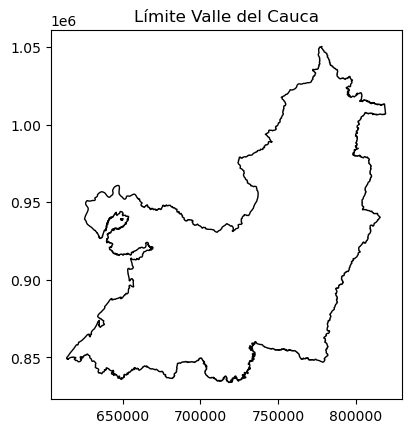

In [36]:
valle = gpd.read_file(limite_valle)
valle.plot(edgecolor='black', facecolor='none')
plt.title("Límite Valle del Cauca")
plt.show()

### Recorte y Reproyección de Capas Temáticas
Para garantizar que todas las capas estén alineadas espacialmente y se puedan analizar entre sí, es necesario:

Reproyectarlas a un sistema de referencia común.
Recortarlas al área de estudio en este caso, el Valle del Cauca.

In [ ]:
# Reproyectar todo a MAGNA-SIRGAS EPSG:3116
def recortar_y_reproyectar(capa, limite, epsg=3116):
    if capa.crs != limite.crs:
        capa = capa.to_crs(limite.crs)
    recorte = gpd.overlay(capa, limite, how='intersection')
    return recorte.to_crs(epsg)

In [ ]:
#5.Aplicación a cada capa 
cartografia = "../Datos/catografiabasica_valle/CBTR_VIA.shp"
proteccion = "../Datos/areas_protegidas/runap_-_Registro_Unico_Nacional_AP.shp"
curvas = "../Datos/catografiabasica_valle/CBRL_CURVAS.shp"
pendiente = "../Datos/suelo_valle/SUELO_SHP/CBRL_PENDIENTES_CN100.shp"
suelo = "../suelo_valle/SUELO_SHP/SLCS_COBERTURA_SUELO.shp"
hidrografia = "../hidrologia_valle/AGUA_SHP/SP_CUERPO_AGUA.shp"


gdf_cartografia = gpd.read_file(cartografia)
gdf_vias = gpd.read_file(cartografia)
gdf_protegidas = gpd.read_file(proteccion)
gdf_curvas = gpd.read_file(curvas)
gdf_pendiente = gpd.read_file(pendiente)
gdf_suelo = gpd.read_file(suelo)
gdf_hidrografia = gpd.read_file(hidrografia)

In [ ]:
# Recortar y reproyectar
vias_valle = recortar_y_reproyectar(gdf_vias, valle)
protegidas_valle = recortar_y_reproyectar(gdf_protegidas, valle)
curvas_valle = recortar_y_reproyectar(gdf_curvas, valle)
pendiente_valle = recortar_y_reproyectar(gdf_pendiente, valle)
suelo_valle = recortar_y_reproyectar(gdf_suelo, valle)
hidro_valle = recortar_y_reproyectar(gdf_hidrografia, valle)


In [1]:
#Prueba